# **Отладка нейронных сетей**

TL;DR: нужно найти и исправить всё что не так. 

Правила игры:
- Нельзя добавлять параметров в сеть---нельзя менять параметры количество/параметры свёрточных и линейных слоёв.
- Читать примеры обучения сетки на пайторче/отдельные куски на стековерфлоу против правил.
- Можно читать документацию к функциям :)
- Количество эпох увеличивать нельзя. *25 эпох хватит всем*.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aosokin/dl_cshse_ami/blob/master/2020-fall/seminars/seminar5/looking_for_bugs.ipynb)

<img src="https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/projects/teaching/dasha.jpg" style="width: 10%;">

# Будем работать с датасетом Fashion-MNIST

Подробнее о датасете [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)

<img src="https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/projects/teaching/fmnist.png" style="width: 10%;">

<img src="https://miro.medium.com/max/2312/1*jXssb_WjoYZgepOCfdQfJA.png" style="width:10%">


In [ ]:
# Стандартные импорты
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [ ]:
# Импорты матплотлиба
import matplotlib.pyplot as plt
%pylab inline
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.dpi'] = 100

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Штука для логгирования, тут багов точно нет
!wget --quiet --show-progress https://raw.githubusercontent.com/senya-ashukha/sparse-vd-pytorch/master/logger.py
from logger import Logger

--2020-10-06 10:58:38--  https://raw.githubusercontent.com/senya-ashukha/sparse-vd-pytorch/master/logger.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2772 (2.7K) [text/plain]
Saving to: ‘logger.py’

logger.py           100%[===================>]   2.71K  --.-KB/s    in 0s      

2020-10-06 10:58:38 (43.7 MB/s) - ‘logger.py’ saved [2772/2772]



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout2d(0.9)
        self.dropout2 = nn.Dropout2d(0.9)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x) 
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn3(x) 
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        return x

In [ ]:
def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    torch.nn.init.constant_(m.weight.data, 0)     
    torch.nn.init.constant_(m.bias.data, 0)

In [ ]:
def train(args, model, device, train_loader, optimizer):
    global logger, epoch
    mean_loss = 0.0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        mean_loss += len(data)/len(train_loader.dataset) * loss.item()
        with torch.no_grad():
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()
    logger.add_scalar(epoch, 'train_loss',  mean_loss)
    logger.add_scalar(epoch, 'train_acc',  100. * correct / len(train_loader.dataset))

In [ ]:
def test(model, device, test_loader):
    global logger, epoch
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    logger.add_scalar(epoch, 'test_loss', test_loss)
    logger.add_scalar(epoch, 'test_acc',  100. * correct / len(test_loader.dataset))

In [ ]:
from types import SimpleNamespace

args = {
  'batch_size': 128,
  'test_batch_size': 1000,
  'epochs': 25,
  'lr': 1e-3,
  'gamma': 0.1,
  'no_cuda': False,
  'log_interval': 2,
}
args = SimpleNamespace(**args)
print('args:', args)

args: namespace(batch_size=128, epochs=25, gamma=0.1, log_interval=2, lr=0.001, no_cuda=False, test_batch_size=1000)


In [ ]:
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


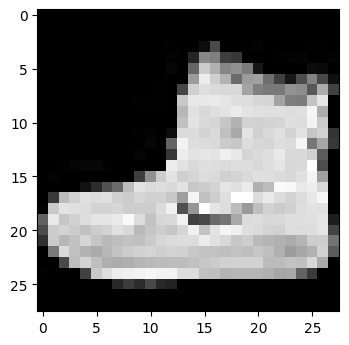

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


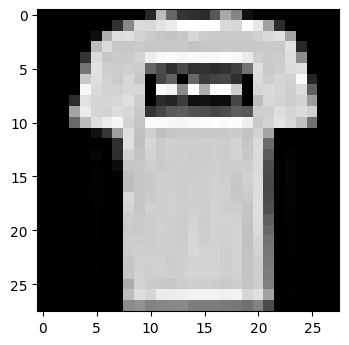

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


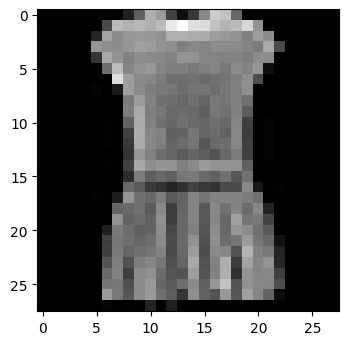

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
transform=transforms.Compose([
    transforms.RandomResizedCrop(28),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.FashionMNIST(
    '../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    num_workers=5, 
    batch_size=args.batch_size)

test_dataset = datasets.FashionMNIST(
    '../data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(
    train_dataset, 
    num_workers=5, 
    batch_size=args.test_batch_size)

plt.imshow(train_dataset.data[0], cmap='gray')
plt.show()
print(train_dataset.classes)

plt.imshow(train_dataset.data[1], cmap='gray')
plt.show()
print(train_dataset.classes)

plt.imshow(train_dataset.data[3], cmap='gray')
plt.show()
print(train_dataset.classes)

In [ ]:
fmt = {'test_loss': '.3f', 'test_acc': '.3f', 'train_loss': '.3f', 'lr': '1.1e'}
logger = Logger('sparse_vd', fmt=fmt)

model = Net().to(device).train()
model = model.apply(weights_init)
optimizer = optim.SGD(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

for epoch in range(1, args.epochs + 1):
    logger.add_scalar(epoch, 'lr', scheduler.get_last_lr()[0])
    train(args, model, device, train_loader, optimizer)
    test(model, device, test_loader)
    scheduler.step()
    if epoch % args.log_interval == 0 or epoch==1:
      logger.iter_info()

  epoch       lr    train_loss    train_acc    test_loss    test_acc
-------  -------  ------------  -----------  -----------  ----------
      1  1.0e-03         0.000         10.0        0.000      10.000
      2  1.0e-04         0.000         10.0        0.000      10.000
      4  1.0e-06         0.000         10.0        0.000      10.000
      6  1.0e-08         0.000         10.0        0.000      10.000
      8  1.0e-10         0.000         10.0        0.000      10.000
     10  1.0e-12         0.000         10.0        0.000      10.000
     12  1.0e-14         0.000         10.0        0.000      10.000
     14  1.0e-16         0.000         10.0        0.000      10.000
     16  1.0e-18         0.000         10.0        0.000      10.000
     18  1.0e-20         0.000         10.0        0.000      10.000
     20  1.0e-22         0.000         10.0        0.000      10.000
     22  1.0e-24         0.000         10.0        0.000      10.000
     24  1.0e-26         0.000    

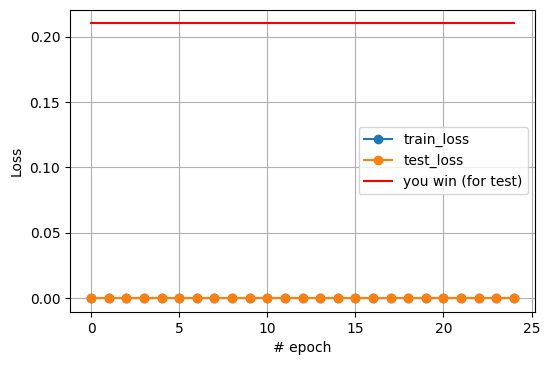

In [ ]:
# Plot train and test loss
train_loss = np.array(logger.scalar_metrics['train_loss'])[:,1]
plt.plot(train_loss, 'o-', label='train_loss')

test_loss = np.array(logger.scalar_metrics['test_loss'])[:,1]
plt.plot(test_loss, 'o-', label='test_loss')

plt.plot([0.21]*len(train_loss), '-', label='you win (for test)', c='r')

plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('# epoch')
plt.legend()

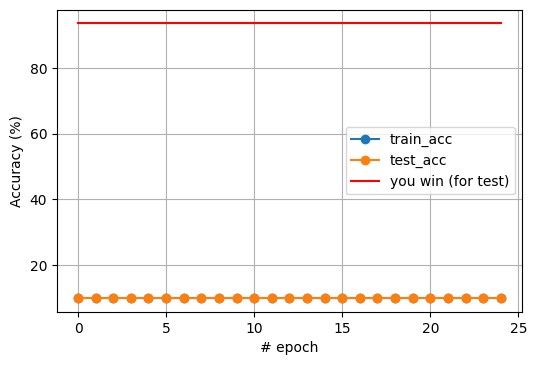

In [ ]:
# Plot train and test accuracy
train_acc = np.array(logger.scalar_metrics['train_acc'])[:,1]
plt.plot(train_acc, 'o-', label='train_acc')

test_acc = np.array(logger.scalar_metrics['test_acc'])[:,1]
plt.plot(test_acc, 'o-', label='test_acc')

plt.plot([93.5]*len(train_acc), '-', label='you win (for test)', c='r')

plt.grid(True)
plt.ylabel('Accuracy (%)')
plt.xlabel('# epoch')
plt.legend()

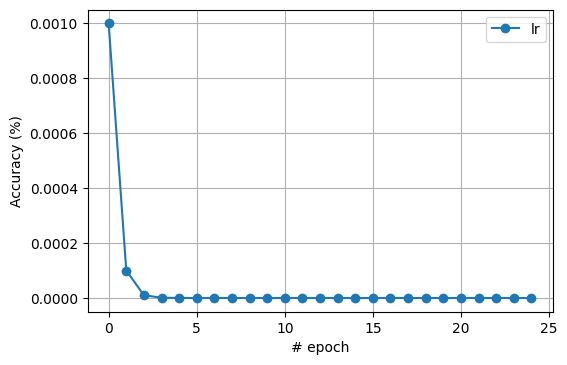

In [ ]:
# Plot learning rate
train_loss = np.array(logger.scalar_metrics['lr'])[:,1]
plt.plot(train_loss, 'o-', label='lr')

plt.grid(True)
plt.ylabel('Accuracy (%)')
plt.xlabel('# epoch')
plt.legend()